In [12]:
#Author: Valeriya Khan
#Date: 10 Feb 2018+

#importing requiered libraries
import h5py
import json
import numpy as np
from sklearn.model_selection import train_test_split
import random as rand

subjects = ['1','2','3','4','5','6','7','8']

#creating list of data of individual persons
data_list= []
for subject in subjects:
    data = {}
    f = h5py.File('subject'+subject+'.mat')
    for k, v in f.items():
        if k != '#refs#':
            for k1,v1 in v.items():
                if k1 == 'z':
                    data['X'] = v1['X'].value
                    data['Y'] = v1['Y'].value
    data_list.append(data)

#creation of separate lists for input and output arrays
X_s = []
y_s = []
for data in data_list:
    X_s.append(np.double(data['X']))
    y_s.append(np.double(data['Y']))
for i in range(len(X_s)):
    X_shape = X_s[i].shape
    X_s[i] = np.reshape(X_s[i], (X_shape[0], X_shape[1]*X_shape[2]))
for i in range(len(y_s)):
    y_s[i] = y_s[i][0]


In [13]:
#for classification purposes outputs should have value 1 or -1
for y in y_s:
    for i in range(0,y.size):
        if (y[i] == 0):
            y[i] = -1

In [14]:
#in order to make learning uniform, all data arrays should have the same size
#all data arrays cut off to the size of the smallest array, elements are chosen randomly 
y_sizes = []
for y in y_s:
    y_sizes.append(y.size)

#y_3 max, y_1 min
for j in range(len(y_s)):
    tempX = X_s[j]
    tempY = y_s[j]
    x_min_shape = X_s[np.argmin(y_sizes)].shape
    y_min_shape = y_s[np.argmin(y_sizes)].shape
    X_s[j] = np.zeros((x_min_shape[0], x_min_shape[1]))
    y_s[j] = np.zeros(y_min_shape[0])
    coeff = rand.sample(range(y_sizes[j]),min(y_sizes))
    for i in range(0, len(coeff)):
        X_s[j][i, :] = tempX[coeff[i],:]
        y_s[j][i] = tempY[coeff[i]]

In [15]:
#standardization of features by removing the mean and scaling to unit variance
from sklearn import preprocessing

for i in range(len(X_s)):
    std_scale = preprocessing.StandardScaler().fit(X_s[i])
    X_s[i] = std_scale.transform(X_s[i])

In [16]:
#creation of one array for all feautures and one array of all outputs
X = []
Y = []
for X_ in X_s:
    X.extend(X_)
for Y_ in y_s:
    Y.extend(Y_)
X = np.array(X)
Y = np.array(Y)

In [17]:
#random shuffling of data
coeff = rand.sample(range(Y.size),Y.size);
tempX = X;
tempY = Y;
X = np.zeros((tempX.shape[0],tempX.shape[1]));
Y = np.zeros((Y.shape[0]));
for i in range (0,len(coeff)):
    X[i,:] = tempX[coeff[i],:];
    Y[i] = tempY[coeff[i]];

[[ 0.50284429  0.49715571]
 [ 0.89688086  0.10311914]
 [ 0.48137052  0.51862948]
 ..., 
 [ 0.84711523  0.15288477]
 [ 0.81629967  0.18370033]
 [ 0.35015311  0.64984689]]
[[ 0.88294582  0.11705418]
 [ 0.92921953  0.07078047]
 [ 0.45647288  0.54352712]
 ..., 
 [ 0.81302562  0.18697438]
 [ 0.73788143  0.26211857]
 [ 0.90807787  0.09192213]]
[[ 0.50391898  0.49608102]
 [ 0.60582036  0.39417964]
 [ 0.79155026  0.20844974]
 ..., 
 [ 0.96389047  0.03610953]
 [ 0.95932082  0.04067918]
 [ 0.83331793  0.16668207]]
[[ 0.87932218  0.12067782]
 [ 0.3030715   0.6969285 ]
 [ 0.47734408  0.52265592]
 ..., 
 [ 0.82657473  0.17342527]
 [ 0.70854677  0.29145323]
 [ 0.93958049  0.06041951]]
[[ 0.94240532  0.05759468]
 [ 0.94633999  0.05366001]
 [ 0.63474845  0.36525155]
 ..., 
 [ 0.58801072  0.41198928]
 [ 0.87162049  0.12837951]
 [ 0.53127483  0.46872517]]
[[ 0.61169397  0.38830603]
 [ 0.17725345  0.82274655]
 [ 0.62415684  0.37584316]
 ..., 
 [ 0.95655563  0.04344437]
 [ 0.83453523  0.16546477]
 [ 0.447

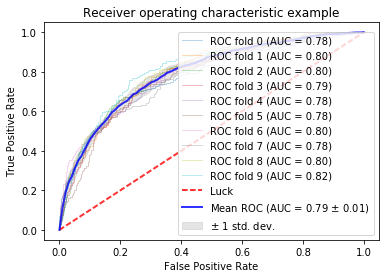

In [18]:
#importing required libraries
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

#Grid search
est = GradientBoostingClassifier(n_estimators=50)
param_grid = {'max_depth': [3, 4, 6],'max_features': [1.0, 0.7, 0.3]}
gs_cv = GridSearchCV(est, param_grid)

#training and creating AUC curve
cv = StratifiedKFold(n_splits=10)
classifier = gs_cv;

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X,Y):
    probas_ = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    print(probas_)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

